# Прогнозирование оттока клиентов для оператора связи

## Описание проекта

В связи с увеличившимся оттоком клиентов от оператора связи требуется подготовить модель, оценивающую риски ухода абонента. Нужно спрогнозировать, уйдёт клиент в ближайшее время или нет. Исходя из полученных результатов будет скорректирована маркетинговая стратегия в отношении высокорисковых пользователей. Для анализа нам предоставлены исторические данные о поведении клиентов и расторжении договоров.

**Цель проекта**

Построить наилучшую модель для прогнозирования, уйдет ли клиент от оператора связи, основываясь на характеристиках и статистике поведения абонента.

**Задачи**

1.	Изучить исходные данные и общую статистику поведения пользователей.
2.	Подготовить данные для анализа, обработать признаки, разделить на обучающую и тестовую выборки.
3.	Исследовать базовые модели и рассмотреть, как меняются показатели оценки в зависимости от примененной модели. Подобрать гиперпараметры.
4.	Выбрать наилучшую модель, по-возможности доработать ее, учитывая дисбаланс классов.
5.	Проверить модели на тестовой выборке и подготовить рекомендации.

## Изучение и обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

Загрузим предоставленные файлы и сохраним их в отдельных переменных.

In [2]:
contract = pd.read_csv('/content/contract.csv')
internet = pd.read_csv('/content/internet.csv')
personal = pd.read_csv('/content/personal.csv')
phone = pd.read_csv('/content/phone.csv')

Посмотрим, столбцы с какими типами данных имеются в датасетах, и есть ли там пропуски.

In [3]:
data = {'contract': contract, 'internet': internet, 'personal': personal, 'phone': phone}

In [4]:
for name, i in data.items():
    print(name)
    display(i.head())
    print(i.info())
    print(i.describe())

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     1414-YADCW     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streamin

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     9866-OCCKE            No
freq             1          3390


Пропущенных значений в таблицах нет. Однако, в них имеется разное количество записей. Так, в contract и personal по 7043 записей, в internet их уже 5517, а в phone - 6361. Это означает, что при соединении данных из этих таблиц, в финальном датасете неизбежно образуются пропущенные значения, которые необходимо будет обработать. Также все столбцы с датами не имеют нужного типа: в колонках BeginDate и EndDate сейчас тип данных object (датафрейм contract). Там же столбец TotalCharges имеет тип object вместо float64. В данных имеется большое количество категориальных признаков, требующих кодирования перед обучением моделей.

Поскольку основной задачей проекта является задача бинарной классификации абонентов (на лояльных пользователей и тех, кто скоро, возможно, покинет ряды клиентов компании), необходимо выделить целевой признак. Здесь он не указан в явном виде, но его вполне можно добавить, ориентируясь на колонку EndDate. Сам столбец EndDate перед обучением моделей нужно удалить в целях недопущения утечки признака.

Добавим целевой признак (назовем его 'Churn'), 0 будет означать, что клиент действующий, а 1 - что уже расторг договор с компанией.

In [5]:
contract['Churn'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Посмотрим, насколько сбалансированы наши группы.

In [6]:
print(contract['Churn'].value_counts(normalize=True))

0    0.73463
1    0.26537
Name: Churn, dtype: float64


Датасет несбалансирован по классам, текущих клиентов в три раза больше, чем бывших.

Соединим таблицы для формирования единого датасета с признаками. За основу возьмем таблицу personal с перечнем клиентов и к ней уже подцепим остальные таблицы.

In [7]:
clients = personal.join(contract.set_index('customerID'), on='customerID', how='left')
clients = clients.join(internet.set_index('customerID'), on='customerID', how='left')
clients = clients.join(phone.set_index('customerID'), on='customerID', how='left')
display(clients.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Fiber optic,No,No,No,No,No,No,No


Переведем столбец BeginDate в формат даты. Также переведем в нужный формат столбец EndDate, предварительно заменив все значения 'No' на 1 февраля 2020г (поскольку информация о договорах актуальна именно на эту дату).

In [8]:
clients['BeginDate'] = pd.to_datetime(clients['BeginDate'], format = '%Y-%m-%d')
clients['EndDate'] = clients['EndDate'].replace('No', '2020-02-01 00:00:00')
clients['EndDate'] = pd.to_datetime(clients['EndDate'], format = '%Y-%m-%d')

Введем дополнительный признак - "время жизни" клиента. Для этого найдем разницу между начальной и конечной датами.

In [9]:
clients['Lifetime'] = (clients['EndDate'] - clients['BeginDate']).dt.days

TotalCharges таблицы contract переведем во float64. Но сначала попробуем понять, почему python посчитал эти данные строками, а не числами. Для этого выведем колонку, предварительно ее отсортировав.

In [10]:
clients['TotalCharges'].sort_values()

936           
3826          
4380          
753           
5218          
         ...  
6646    997.75
5598     998.1
3686    999.45
3353     999.8
2845     999.9
Name: TotalCharges, Length: 7043, dtype: object

Оказывается, в датафрейме имеются пустые строки, но обозначены они не как пропущенные значения, а просто как ' '. Посчитаем количество этих записей, выведем их и посмотрим, что с ними не так.

In [11]:
print('Количество записей', len(clients[clients['TotalCharges'] == ' ']))
print('Доля от датасета', np.round(len(clients[clients['TotalCharges'] == ' '])/len(clients), 4))
display(clients[clients['TotalCharges'] == ' '])

Количество записей 11
Доля от датасета 0.0016


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Lifetime
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Интересно, что все эти записи заведены в день выгрузки данных - 1 февраля 2020г. Поскольку подобных клиентов очень мало (около 0,16% от всех данных), а их наличие не несет практической пользы для обучения модели, то строки удаляем.

In [12]:
clients = clients[clients['TotalCharges'] != ' ']

Теперь переведем оставшиеся значения столбца TotalCharges во float.

In [13]:
clients['TotalCharges'] = clients['TotalCharges'].astype(np.float64)

Посмотрим, что за таблица получилась.

In [14]:
print(clients.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  Churn             7032 non-null   int64         
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity    5512 n

С типами данных теперь все в порядке. Однако при соединении таблиц образовалось много пропущенных значений, которые тоже нужно обработать. Поскольку пропуски в категориальных признаках, где указаны варианты Yes или No, заменим NaN на категорию No (т.к., скорее всего, эти клиенты не пользовались данными услугами).

In [15]:
null_contain = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for i in null_contain:
    clients[i] = clients[i].fillna('No')
print(clients.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  Churn             7032 non-null   int64         
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

По аналогии с другими столбцами заменим в заголовках gender на Gender (с большой буквы).

In [16]:
clients.rename(columns={'gender': 'Gender'}, inplace=True)

На всякий случай, проверим датасет на наличие дубликатов.

In [17]:
print('Количество дубликатов в наборе данных: {}'.format(clients.duplicated().sum()))

Количество дубликатов в наборе данных: 0


### Вывод

С целью прогнозирования оттока клиентов, оператор связи предоставил для анализа 4 таблицы: информацию о договорах, интернет-услугах, услугах телефонии и персональных данных клиента. Это весьма неплохой формат для хранения и обработки информации в реляционных базах данных. Но для нашего исследования в чистом виде он не подходит, поскольку представляет собой довольно разрозненный и фрагментарный набор. По этой причине осуществлено объединение таблиц, чтобы связать статистику по пользователям, их затратам и получаемым услугам.

Для удобства работы с данными и построения моделей выделен целевой признак - создана колонка Churn. Выявлена несбалансированность классов, текущих клиентов примерно в три раза больше, чем бывших. В столбцах с датами (BeginDate и EndDate) тип данных object заменен на datetime, а в колонке TotalCharges на float64. Введен дополнительный параметр (для каждого пользователя), необходимый для дальнейшего анализа - "время жизни" клиента. Для этого рассчитана разница между начальной и конечной датами.

Дубликатов в получившемся датафрейме не обнаружено.

## Анализ данных

Выведем основные статистики по числовым данным.

In [18]:
display(clients.describe())

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,Lifetime
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,64.798208,2283.300441,0.265785,987.538538
std,0.368844,30.085974,2266.771362,0.441782,747.153663
min,0.000000,18.250000,18.800000,0.000000,30.000000
25%,0.000000,35.587500,401.450000,0.000000,275.000000
50%,0.000000,70.350000,1397.475000,0.000000,883.000000
75%,0.000000,89.862500,3794.737500,1.000000,1676.000000
max,1.000000,118.750000,8684.800000,1.000000,2191.000000


Основная часть пользователей не является людьми в годах, а вполне себе экономически активна. Интересно, что среднее значение ежемесячных оплат меньше медианного. Половина абонентов пользуется услугами компании более 2 лет. В целом, каких-то аномальных значений не выявлено.

Построим графики распределения ежемесячных платежей, суммы всех платежей за все время пользования услугами оператора и времени жизни клиента.

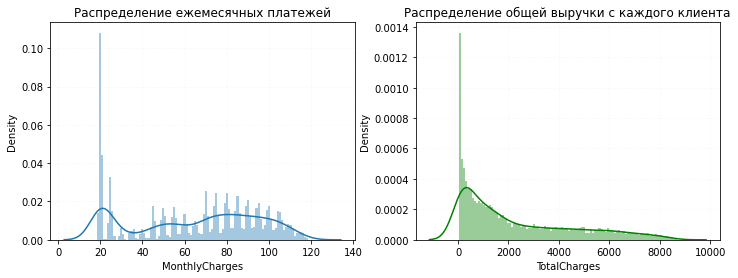

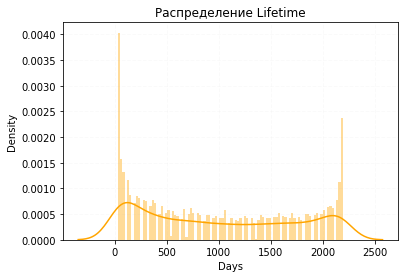

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.distplot(clients['MonthlyCharges'], bins=100, ax=ax[0])
ax[0].set(title='Распределение ежемесячных платежей')
ax[0].grid(alpha=0.05, linestyle='--', linewidth=1)

sns.distplot(clients['TotalCharges'], bins=100, color='green', ax=ax[1])
ax[1].set(title='Распределение общей выручки с каждого клиента')
ax[1].grid(alpha=0.05, linestyle='--', linewidth=1)

plt.show()

ax = sns.distplot(clients['Lifetime'], bins=100, color='orange')
ax.set(title='Распределение Lifetime', xlabel='Days')
ax.grid(alpha=0.05, linestyle='--', linewidth=1)

Распределения не выглядят нормальными. На первом графике (ежемесячные платежи) выделяется высокий пик в районе 20, а после него - длинный толстый хвост. Скорее всего, есть какой-то тариф (стоимостью 20), на котором останавливается множество пользователей, а другие услуги не подключают.

Распределение общей выручки с каждого пользователя выглядит более плавным, но и здесь есть пик в районе чуть больше нуля. Возможно, это новые пользователи или абоненты, которые решили сразу же уйти от оператора, едва подключившись.

График LT кажется еще более интересным. Вогнутая чашеобразная форма с пиками по краям свидетельствует о наличии двух больших групп - очень лояльных абонентов (которые являются клиентами компании более 6 лет) и абонентов, которые пользовались услугами оператора совсем недолго. В последний сегмент могут входить как "экстремальные временщики", быстро расторгнувшие договор, так и недавно подключившиеся пользователи. Еще есть вероятность, что часть лояльных пользователей могла сменить тариф, заключить новый договор и, таким образом, "затереть" информацию о более раннем контракте.

Лояльный пик мог возникнуть из-за того, что в электронные базы эти клиенты внеслись одновременно, и им была присвоена единая дата договора. Либо какой-то тариф устарел, и они были переведены на другой тариф с заключением нового договора.

Попробуем построить такие же графики распределений, только разложим в них абонентов на 2 группы: текущие клиенты и клиенты, которые ушли.

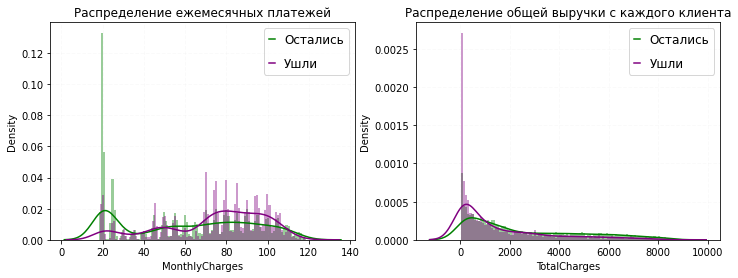

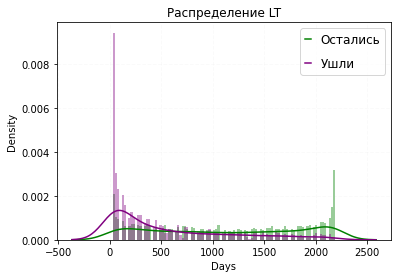

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.distplot(clients[clients['Churn'] == 0]['MonthlyCharges'], bins=100, color='green', ax=ax[0])
sns.distplot(clients[clients['Churn'] == 1]['MonthlyCharges'], bins=100, color='purple', ax=ax[0])
ax[0].set(title='Распределение ежемесячных платежей')
ax[0].grid(alpha=0.05, linestyle='--', linewidth=1)
ax[0].legend(["Остались", "Ушли"], loc=1, fontsize='large', labelspacing=0.9, handlelength=0.5) 

sns.distplot(clients[clients['Churn'] == 0]['TotalCharges'], bins=100, color='green', ax=ax[1])
sns.distplot(clients[clients['Churn'] == 1]['TotalCharges'], bins=100, color='purple', ax=ax[1])
ax[1].set(title='Распределение общей выручки с каждого клиента')
ax[1].grid(alpha=0.05, linestyle='--', linewidth=1)
ax[1].legend(["Остались", "Ушли"], loc=1, fontsize='large', labelspacing=0.9, handlelength=0.5) 

plt.show()

ax = sns.distplot(clients[clients['Churn'] == 0]['Lifetime'], bins=100, color='green')
ax = sns.distplot(clients[clients['Churn'] == 1]['Lifetime'], bins=100, color='purple')
ax.set(title='Распределение LT', xlabel='Days')
ax.grid(alpha=0.05, linestyle='--', linewidth=1)
ax.legend(["Остались", "Ушли"], loc=1, fontsize='large', labelspacing=0.9, handlelength=0.5) 

В разрезе ежемесячных платежей группы выделяются чуть проще (хотя основания графиков совпадают). Чем меньше стоимость услуг, тем больше шансов, что абонент останется. Тем не менее, существует довольно большая прослойка абонентов, которые готовы платить за дополнительные опции. А вот по общему доходу с каждого клиента разделение сделать сложно: распределения практически накладываются друг на друга.
    
Что касается "времени жизни", то чем дольше клиент пользуется услугами, тем меньше вероятность его ухода. Обратное же не совсем верно: имеется пик из ушедших потребителей именно на коротком сроке, но там же довольно много новых текущих пользователей, по которым еще рано делать вывод. Мы не знаем, останутся они или уйдут, пока они в состоянии "суперпозиции".
    
Посмотрим, как соотносятся между собой платежи, возрастная группа, вся "пожизненная" выручка с каждого клиента, время пользования услугами и отток.

In [21]:
def scatter_draw(xdata_0, ydata_0, zdata_0, xdata_1, ydata_1, zdata_1, title, xlabel, ylabel, zlabel):
    
    """
    Функция для построения 3D-графика рассеяния, применяется при наличии двух классов.
    
    xdata_0, ydata_0, zdata_0 - 3 столбца по осям x, y, z для первого класса (0)
    xdata_1, ydata_1, zdata_1 - 3 столбца по осям x, y, z для второго класса (1)
    title - заголовок графика
    xlabel, ylabel, zlabel - подписи осей x, y, z
    """ 
        
    ax.scatter(xdata_0, ydata_0, zdata_0, alpha=0.1, s=10, color='green')
    ax.scatter(xdata_1, ydata_1, zdata_1, alpha=0.1, s=10, color='red')
    ax.grid(alpha=0.2, linestyle='--', linewidth=1)
    ax.set_title(title, fontsize='large')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_zlabel(zlabel)
    ax.legend(["Остались", "Ушли"], loc=3, fontsize='large', labelspacing=0.9, handlelength=0.5) 

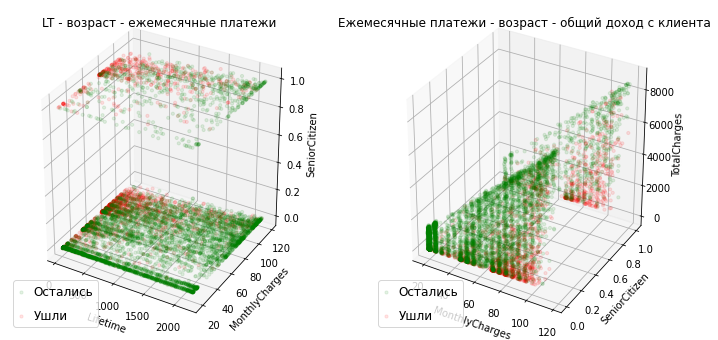

In [22]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
scatter_draw(clients[clients['Churn'] == 0]['Lifetime'], clients[clients['Churn'] == 0]['MonthlyCharges'], clients[clients['Churn'] == 0]['SeniorCitizen'],
             clients[clients['Churn'] == 1]['Lifetime'], clients[clients['Churn'] == 1]['MonthlyCharges'], clients[clients['Churn'] == 1]['SeniorCitizen'],
             'LT - возраст - ежемесячные платежи', 'Lifetime', 'MonthlyCharges', 'SeniorCitizen')
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter_draw(clients[clients['Churn'] == 0]['MonthlyCharges'], clients[clients['Churn'] == 0]['SeniorCitizen'], clients[clients['Churn'] == 0]['TotalCharges'],
             clients[clients['Churn'] == 1]['MonthlyCharges'], clients[clients['Churn'] == 1]['SeniorCitizen'], clients[clients['Churn'] == 1]['TotalCharges'],
             'Ежемесячные платежи - возраст - общий доход с клиента', 'MonthlyCharges', 'SeniorCitizen', 'TotalCharges')

По графикам можно сделать вывод, что размер платежей и доход клиента имеют значение. Ожидаемо, что чем сложнее абоненту оплачивать услуги, тем выше вероятность расторжения договора.

Выведем корреляционную матрицу и посмотрим, какие зависимости есть между признаками.

In [23]:
print('\n', 'Корреляционная матрица, коэф. Пирсона')
display(clients.corr().style.background_gradient(cmap='coolwarm'))


 Корреляционная матрица, коэф. Пирсона


,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,Lifetime
SeniorCitizen,1.000000,0.219874,0.102411,0.150541,0.015630
MonthlyCharges,0.219874,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.102411,0.651065,1.000000,-0.199484,0.825811
Churn,0.150541,0.192858,-0.199484,1.000000,-0.354496
Lifetime,0.015630,0.246715,0.825811,-0.354496,1.000000


Наблюдается положительная корреляция между оттоком, ежемесячными платежами и возрастной группой (но здесь нужно отметить, что SeniorCitizen - бинарный признак), а также отрицательная корреляция между оттоком и временем жизни клиента и общей суммой, оплаченной за услуги связи. Отметим тот факт, что две последние колонки сильно коррелируют между собой (ну да, чем дольше пользователь является абонентом компании, тем больше денег он оставляет).
Но иногда закономерности могут носить нелинейный характер, и в этом случае коэффициент корреляции может оказаться бесполезным показателем. Рассчитаем коэффициент ранговой корреляции Спирмена, он более устойчив к выбросам (если они есть). Используем тот же код, только функции corr() передадим параметр method='spearman'.

In [24]:
print('\n', 'Корреляционная матрица, коэф. Спирмена')
display(clients.corr(method='spearman').style.background_gradient(cmap='coolwarm'))


 Корреляционная матрица, коэф. Спирмена


,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,Lifetime
SeniorCitizen,1.000000,0.220737,0.107248,0.150541,0.016001
MonthlyCharges,0.220737,1.000000,0.638032,0.184167,0.272827
TotalCharges,0.107248,0.638032,1.000000,-0.232190,0.888230
Churn,0.150541,0.184167,-0.232190,1.000000,-0.378307
Lifetime,0.016001,0.272827,0.888230,-0.378307,1.000000


В целом значения корреляции остались примерно такими же.

Теперь попробуем изучить влияние категориальных признаков с помощью критерия X2 и расчета p-value. Наша нулевая гипотеза состоит в том, что между столбцом Churn и остальными переменными нет никакой зависимости. За пороговый уровень значимости примем 0.01. 
    
Воспользуемся модулем chi2_contingency из библиотеки scipy.stats и выведем лишь те категориальные признаки, которые являются статистически значимыми для прогнозирования целевой переменной (т.е. для которых p-value оказался ниже порогового значения).

In [25]:
categ_col = list(clients.select_dtypes(['object']).columns[1:])

In [26]:
chi_tab = pd.DataFrame(columns=['features', 'chi2', 'p-value'])
for feat in categ_col:
    chisqt = pd.crosstab(clients['Churn'], clients[feat], margins=True)
    chi2, p_val, df, exp = chi2_contingency(chisqt)
    if p_val < 0.01:
        chi_tab = chi_tab.append({'features': feat, 'chi2': chi2,
                                  'p-value': p_val, 'df': df}, ignore_index=True)
    
display(chi_tab.sort_values(by='p-value'))

,features,chi2,p-value,df
2,Type,1179.545829,1.278469e-251,6.0
5,InternetService,728.695614,3.891743e-154,6.0
4,PaymentMethod,645.429900,3.972166e-134,8.0
3,PaperlessBilling,257.756252,1.388280e-54,4.0
6,OnlineSecurity,206.272375,1.683156e-43,4.0
9,TechSupport,190.787516,3.589767e-40,4.0
1,Dependents,187.127763,2.195068e-39,4.0
0,Partner,158.181873,3.587783e-33,4.0
7,OnlineBackup,47.637842,1.122941e-09,4.0
8,DeviceProtection,30.810351,3.346556e-06,4.0


Практически все категориальные признаки, скорее всего, существенны для прогнозирования. Наименьшее значение p-value у трех из них: Type, InternetService и PaymentMethod.

### Вывод

Предварительный анализ не выявил отдельных аномальных значений. Тем не менее распределения платежей и общего времени использования услуг не похожи на нормальные. Среднее значение ежемесячных оплат меньше медианного, но при этом на графике большой толстый хвост вправо. Это означает, что существует немалое количество пользователей, которые стремятся к экономии и не используют дополнительные пакеты. А по краям графика Lifetime наблюдаются два больших пика - групп очень лояльных пользователей и пользователей с очень небольшим клиентским опытом. Примерно половина абонентов пользуется услугами компании более 2 лет. 

Обнаружена положительная корреляция между оттоком абонентов, величиной ежемесячных платежей и возрастным статусом клиента, а также отрицательная корреляция между оттоком, временем жизни клиента и общей суммой, оплаченной за услуги связи. В целом, здесь нет сюрпризов, чем больший доход имеет клиент, тем больше услуг он может себе позволить. Но для людей пенсионного возраста или имеющих иждивенцев на попечении, стоимость тарифов может быть критически важной.

Среди категориальных переменных наибольшей значимостью для целевого признака (Churn) обладают Type, InternetService и PaymentMethod.

## Подготовка данных для обучения

Разделим датасет на набор прогнозирующих факторов и целевой признак. Из списка прогнозирующих признаков удалим также ID клиента, даты заключения/ расторжения договора на обслуживание, а также TotalCharges из-за сильно корреляции с другим фактором.

In [27]:
target = clients['Churn']
features = clients.drop(['Churn', 'customerID', 'BeginDate', 'EndDate', 'TotalCharges'], axis=1)

Разделим наши обучающие признаки на две выборки: обучающую и тестовую. В параметры функции train_test_split добавим stratify, чтобы сохранить пропорцию классов в разных наборах. Посмотрим, выборки каких размеров у нас получились.

In [28]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, stratify=target, random_state=12345)
print('Train', features_train.shape, target_train.shape)
print('Test', features_test.shape, target_test.shape)

Train (5274, 17) (5274,)
Test (1758, 17) (1758,)


В датасете также имеются категориальные признаки, от которых может зависеть, уйдет ли клиент от оператора связи или нет. Поскольку категорий в самих столбцах мало, используем технику прямого кодирования (One-Hot Encoding). К тому же она работает со всеми моделями.

Перед кодированием сохраним копии датафреймов с признаками для обучения модели градиентного бустинга (в ней есть встроенные методы обработки подобных признаков) в переменных features_train_0 и features_test_0.

In [29]:
features_train_0 = features_train.copy()
features_test_0 = features_test.copy()

features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
display(features_train.head())

,SeniorCitizen,MonthlyCharges,Lifetime,Gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
2165,0,20.20,396,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3814,0,88.70,2191,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1
2514,1,89.70,760,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1
3837,0,105.65,122,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0
2573,0,54.75,31,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


Чтобы привести признаки к единому масштабу, стандартизируем их методом StandardScaler и выведем первые строки получившейся таблицы (тренировочные данные). Данный шаг применим к двум наборам данных: к датафрейму с закодированными категориальными признаками и незакодированными.

In [30]:
numeric = ['MonthlyCharges', 'Lifetime']

scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

scaler.fit(features_train_0[numeric])
features_train_0[numeric] = scaler.transform(features_train_0[numeric])
features_test_0[numeric] = scaler.transform(features_test_0[numeric])

display(features_train.head())

,SeniorCitizen,MonthlyCharges,Lifetime,Gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
2165,0,-1.482494,-0.792953,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3814,0,0.790277,1.617661,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1
2514,1,0.823457,-0.304116,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1
3837,0,1.352664,-1.160924,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0
2573,0,-0.336155,-1.283134,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


### Вывод

С целью подготовки данных к обучению часть категориальных признаков была удалена из набора из-за отсутствия прогнозируемой значимости или возможной утечки признака. Среди них ID клиента, даты заключения и расторжения договора.

Остальные категориальные признаки теоретически могут повлиять на решения модели (вдруг, мужчины с иждивенцами более склонны к побегу), поэтому они были оставлены в датафрейме и обработаны методом прямого кодирования (One-Hot Encoding). Отдельно сохранен датафрейм с незакодированными столбцами для модели градиентного бустинга.

Набор данных разделен на обучающую и тестовую выборки. А чтобы модель не считала какой-то фактор более значимым только из-за большого количества знаков до запятой, все признаки были масштабированы с помощью StandardScaler(). Чтобы заранее не передавать информацию модели, как распределены данные в тестовой выборке, шкалирование произведено уже после разделения датасета на обучающую и тестовую выборки.

## Обучение моделей

В проекте рассмотрено восемь моделей: дерево решений, случайный лес, логистическая регрессия, наивный байесовский классификатор, метод опорных векторов, градиентный бустинг (LightGBM), метод ближайших соседей и несложная нейросеть.

Оптимальные гиперпараметры подберем с помощью функции GridSearchCV(). Поскольку перебирать гиперпараметры мы будем не один раз, объявим функцию для перебора этих гиперпараметров. На вход она будет принимать перечень параметров, тип модели, набор обучающих признаков и обучающий целевой признак. Возвращать функция будет метрику ROC-AUC.

In [31]:
def select_params(params, model, f_train, t_train):
    """
    Функция для подбора гиперпараметров моделей.
    
    params - словарь с параметрами (например, {'max_depth': range(1,11), 'min_samples_split': [2,4,6]})
    model - модель (например, DecisionTreeClassifier)
    f_train - датафрейм с прогнозируюшими факторами
    t_train - целевой признак (зависимая переменная)
    """       
    
    mod = GridSearchCV(model, params, scoring='roc_auc')
    %time mod.fit(f_train, t_train)
    print('ROC-AUC лучшей модели на обучающей выборке:', mod.best_score_.round(3))
    print(mod.best_params_)

Поскольку кроме точности прогнозирования нам желательно оценить и скорость работы модели, мы также будем фиксировать время отработки кода. Для удобства оценки вынесем все зафиксированное время обучения моделей в отдельную (заранее объявленную) переменную (словарь). Позже выведем эти данные в общую сравнительную таблицу для всех алгоритмов (кроме нейросети).

In [32]:
fit_time = {}

### Дерево решений

Первым рассмотрим дерево решений. Выведем метрику ROC-AUC, какая получается, если не "докручивать" модель, а использовать гиперпараметры, установленные по умолчанию.

Применим нашу функцию для подбора параметров, т.к. она основана на кросс-валидации (нет необходимости проверять результат на валидационной выборке, позже используем сразу тестовую). Просто передадим ей пустые параметры.

In [33]:
params = {}
select_params(params, DecisionTreeClassifier(random_state=12345), features_train, target_train)

CPU times: user 140 ms, sys: 1.86 ms, total: 142 ms
Wall time: 144 ms
ROC-AUC лучшей модели на обучающей выборке: 0.712
{}


Теперь попробуем подобрать гиперпараметры для модели.

In [34]:
params = {'max_depth': range(1,11), 'min_samples_split': [2,3,4,5,6,7,8,9,10], 
          'min_samples_leaf': range(1,11), 'class_weight': [None, 'balanced']}
select_params(params, DecisionTreeClassifier(random_state=12345, class_weight='balanced'),
              features_train, target_train)

CPU times: user 2min 7s, sys: 781 ms, total: 2min 8s
Wall time: 2min 7s
ROC-AUC лучшей модели на обучающей выборке: 0.848
{'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}


Лучше всего сработала модель с 6 узлами, 2 минимально возможными объектами для разделения внутри узла и 6 минимальными объектами в листе.

Сохраним нашу модель с подобранным количеством узлов и объектов в переменной model_dt.

In [35]:
start= timer()
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_split=2, 
                                  min_samples_leaf=6, class_weight='balanced')
model_dt.fit(features_train, target_train)
end = timer()
fit_time['Decision Tree'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Случайный лес

Теперь попробуем использовать для классификации не одно дерево, а их ансамбль. Сначала применим гиперпараметры, установленные в алгоритме по дефолту.

In [36]:
params = {}
select_params(params, RandomForestClassifier(random_state=12345), features_train, target_train)

CPU times: user 3.07 s, sys: 37.8 ms, total: 3.11 s
Wall time: 3.11 s
ROC-AUC лучшей модели на обучающей выборке: 0.831
{}


Результаты неплохие, посмотрим, есть ли возможность сделать модель еще лучше. Снова запустим нашу функцию для подбора гиперпараметров, передав ей варианты глубины и количества деревьев, критерий разделения и взвешивания классов.

In [37]:
params = {'max_depth': [6,8,10], 'n_estimators': [30, 60, 90], 'criterion': ['gini', 'entropy'], 
          'class_weight': [None, 'balanced']}
select_params(params, RandomForestClassifier(random_state=12345, class_weight='balanced'),
              features_train, target_train)

CPU times: user 43 s, sys: 214 ms, total: 43.2 s
Wall time: 43.1 s
ROC-AUC лучшей модели на обучающей выборке: 0.855
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 90}


Результаты значительно улучшились. Сохраним модель с подобранными гиперпараметрами.

In [38]:
start= timer()
model_rf = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=8, 
                                  criterion='entropy', class_weight='balanced')
model_rf.fit(features_train, target_train)
end = timer()
fit_time['Random Forest'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Логистическая регрессия

Проверим, насколько правильно будет разделять классы логистическая регрессия. Выведем итоги работы модели без подбора гиперпараметров.

In [39]:
params = {}
select_params(params, LogisticRegression(random_state=12345), features_train, target_train)

CPU times: user 362 ms, sys: 251 ms, total: 613 ms
Wall time: 332 ms
ROC-AUC лучшей модели на обучающей выборке: 0.84
{}


Модель продемонстрировала неплохие результаты, примерно сравнимые со случайным лесом. Добавим в функцию варианты гиперпараметров и запустим снова.

In [40]:
params = {'solver': ['liblinear', 'saga'],
          'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']}
select_params(params, LogisticRegression(random_state=12345, class_weight='balanced'), 
              features_train, target_train)

CPU times: user 2.84 s, sys: 2.23 s, total: 5.07 s
Wall time: 2.63 s
ROC-AUC лучшей модели на обучающей выборке: 0.84
{'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


Доработка модели никак не повлияла на ее качество. Поэтому сохраним модель в переменной model_lr с гиперпараметрами, используемыми по умолчанию, добавив только значение random_state.

In [41]:
start= timer()
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)
end = timer()
fit_time['Logistic Regression'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Наивный байесовский классификатор

Рассмотрим еще одну модель - наивный байесовский классификатор.

In [42]:
params = {}
select_params(params, GaussianNB(), features_train, target_train)

CPU times: user 78.7 ms, sys: 64.1 ms, total: 143 ms
Wall time: 76.2 ms
ROC-AUC лучшей модели на обучающей выборке: 0.824
{}


Проверим, возможно ли улучшить модель.

In [43]:
params = {'var_smoothing': [0.01, 0.05, 0.1, 0.15, 0.20], 
          'priors': [[0.05, 0.95], [0.15, 0.85], [0.25, 0.75], [0.4, 0.6]]}
select_params(params, GaussianNB(), features_train, target_train)

CPU times: user 907 ms, sys: 13.9 ms, total: 921 ms
Wall time: 924 ms
ROC-AUC лучшей модели на обучающей выборке: 0.83
{'priors': [0.05, 0.95], 'var_smoothing': 0.2}


В общем, улучшения небольшие, но сохраним в таком виде.

In [44]:
start= timer()
model_bc = GaussianNB(var_smoothing=0.2, priors=[0.05, 0.95])
model_bc.fit(features_train, target_train)
end = timer()
fit_time['GaussianNB'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Метод опорных векторов

Применим для сегментации наших клиентов метод опорных векторов.

In [45]:
params = {}
select_params(params, SVC(random_state=12345, probability=True), features_train, target_train)

CPU times: user 24.4 s, sys: 179 ms, total: 24.5 s
Wall time: 24.4 s
ROC-AUC лучшей модели на обучающей выборке: 0.799
{}


Попробуем изменить некоторые гиперпараметры модели. Данные перекрываются, поэтому настроим степень размытости отступа, подобрав гиперпараметр С (должно быть небольшое значение). Судя по графикам в разделе анализа предоставленных данных (по крайней мере, числовая их часть), граница принятия решений может быть линейной. Но из-за большого количества категориальных признаков тип ядра тоже лучше подобрать.

In [46]:
params = {'C': [1.5, 1.75, 2, 2.25], 'kernel': ['linear', 'rbf', 'sigmoid'], 
          'decision_function_shape': ['ovo', 'ovr']}
select_params(params, SVC(random_state=12345, probability=True), features_train, target_train)

CPU times: user 6min 7s, sys: 1.47 s, total: 6min 8s
Wall time: 6min 6s
ROC-AUC лучшей модели на обучающей выборке: 0.836
{'C': 1.5, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


С новыми гиперпараметрами качество улучшилось. Сохраним модель в таком виде.

In [47]:
start= timer()
model_sv = SVC(C=2, kernel='linear',  probability=True, decision_function_shape='ovo', random_state=12345)
model_sv.fit(features_train, target_train)
end = timer()
fit_time['Support Vector Classification'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Градиентный бустинг

Рассмотрим Light Gradient Boosted Machine (LightGBM). Поскольку в данном алгоритме есть встроенная возможность обработки категориальных признаков, то для обучения используем датафрейм без кодирования. Он сохранен в переменной features_train_0.
Только изменим в нем тип данных на 'category'. Точно так же поступим и с тестовой выборкой (ее мы используем позже на этапе анализа эффективности моделей).

In [48]:
categ_list = list(features_train_0.select_dtypes(['object']).columns)

In [49]:
cat_feat = features_train_0[categ_list]
for i in cat_feat:
    features_train_0[i] = features_train_0[i].astype('category')

cat_feat = features_test_0[categ_list]
for i in cat_feat:
    features_test_0[i] = features_test_0[i].astype('category')

Запустим функцию подбора гиперпараметров без указания вариантов, чтобы посмотреть на результат базовой модели.

In [50]:
params = {}
select_params(params, LGBMClassifier(random_state=12345), features_train_0, target_train)

CPU times: user 2.1 s, sys: 103 ms, total: 2.21 s
Wall time: 1.32 s
ROC-AUC лучшей модели на обучающей выборке: 0.885
{}


Пока это лучший результат из всех. Проверим, будет ли он выше, если подобрать гиперпараметры.

In [51]:
params = {'n_estimators': [70, 100], 'max_depth': [6, 8, 10, 12], 'class_weight': [None, 'balanced'],
         'learning_rate': [0.1, 0.01, 0.001]}
select_params(params, LGBMClassifier(random_state=12345), features_train_0, target_train)

CPU times: user 1min 17s, sys: 3.25 s, total: 1min 20s
Wall time: 47.6 s
ROC-AUC лучшей модели на обучающей выборке: 0.888
{'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}


Качество модели улучшилось ненамного. Сохраним модель с новыми парамтерами.

In [52]:
start= timer()
model_gb = LGBMClassifier(random_state=12345, class_weight='balanced', max_depth=12, n_estimators=100)
model_gb.fit(features_train_0, target_train)
end = timer()
fit_time['LGBMClassifier'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Метод ближайших соседей

Наконец, рассмотрим метод ближайших соседей. Сначала с гиперпараметрами по умолчанию.

In [53]:
params = {}
select_params(params, KNeighborsClassifier(), features_train, target_train)

CPU times: user 574 ms, sys: 5.93 ms, total: 580 ms
Wall time: 598 ms
ROC-AUC лучшей модели на обучающей выборке: 0.769
{}


Попробуем подобрать гиперпараметры.

In [54]:
params = {'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance'], 
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
select_params(params, KNeighborsClassifier(), features_train, target_train)

CPU times: user 22.1 s, sys: 3.96 s, total: 26.1 s
Wall time: 21.3 s
ROC-AUC лучшей модели на обучающей выборке: 0.826
{'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}


Эффективность модели повысилась, однако, это пока одна из самых слабых моделей. Сохраним в таком виде.

In [55]:
start= timer()
model_knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=20, weights='uniform')
model_knn.fit(features_train, target_train)
end = timer()
fit_time['KNeighbors Classifier'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

### Нейросеть

Проверим, может ли несложная нейросеть показать результаты лучше, чем у предыдущих моделей. Здесь попробуем подобрать гиперпараметры без использования нашей функции select_params.

In [56]:
optim = Adam(lr=0.01)

model_nn = keras.models.Sequential()
model_nn.add(keras.layers.Dense(units=32, input_dim=features_train.shape[1], 
                             activation='sigmoid')) 
model_nn.add(Dropout(0.25))
model_nn.add(keras.layers.Dense(units=1, input_dim=features_train.shape[1], 
                             activation='sigmoid'))
model_nn.compile(loss='binary_crossentropy', optimizer=optim, metrics=[tf.keras.metrics.AUC()])

model_nn.fit(features_train, target_train, validation_data=(features_test, target_test), epochs=5, verbose=2)

predictions = (model_nn.predict(features_test)).round(0)
print("Accuracy:", accuracy_score(target_test, predictions))

Epoch 1/5
165/165 - 2s - loss: 0.4609 - auc: 0.8022 - val_loss: 0.4151 - val_auc: 0.8481
Epoch 2/5
165/165 - 0s - loss: 0.4347 - auc: 0.8293 - val_loss: 0.4147 - val_auc: 0.8498
Epoch 3/5
165/165 - 0s - loss: 0.4298 - auc: 0.8338 - val_loss: 0.4123 - val_auc: 0.8508
Epoch 4/5
165/165 - 0s - loss: 0.4286 - auc: 0.8349 - val_loss: 0.4131 - val_auc: 0.8508
Epoch 5/5
165/165 - 0s - loss: 0.4290 - auc: 0.8353 - val_loss: 0.4106 - val_auc: 0.8508
Accuracy: 0.8128555176336746


Довольно простая нейросеть продемонстрирвала неплохие результаты, но градиентный бустинг не превзошла.

### Вывод

Из всех рассмотренных в разделе моделей лучшее качество продемонстрировал градиентный бустинг. На втором месте по эффективности случайный лес. Проверим наших лидеров на тестовой выборке и посмотрим, насколько сильно изменится итоговый результат.

## Анализ моделей

Для оценки моделей используем сразу несколько метрик и создадим константную модель, где стратегия формирования предсказаний будет ориентирована на максимальное значение ROC-AUC.

In [57]:
params = {'strategy': ['stratified', 'prior', 'most_frequent', 'uniform']}
select_params(params, DummyClassifier(random_state=12345), features_train, target_train)

CPU times: user 95.1 ms, sys: 4.03 ms, total: 99.1 ms
Wall time: 99.2 ms
ROC-AUC лучшей модели на обучающей выборке: 0.502
{'strategy': 'stratified'}


Сохраним модель.

In [58]:
start = timer()
constant_model = DummyClassifier(random_state=12345, strategy='stratified')
constant_model.fit(features_train, target_train)
end = timer()
fit_time['Dummy'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

Теперь выведем таблицу с основными метриками всех моделей (кроме нейросети) и сравним их. Для этого напишем функцию, которая будет подсчитывать accuracy, recall, precision, f1-score, AUC, а также время, затраченное на обучение и прогнозирование. 

In [59]:
def compare_table(models, features, features0, target, time):
    """
    Функция для построения таблицы с основными метриками моделей.
    
    models - словарь с моделями ({'name': model})
    features - датафрейм с прогнозируюшими факторами, где категориальные признаки закодированы
    features0 - датафрейм с прогнозируюшими факторами, где категориальные признаки без кодирования (для моделей градиентного бустинга, имеющих втроенные методы обработки подобных признаков)
    target - целевой признак
    time - словарь с временем обучения моделей ({'name': time})
    """       
        
    df = pd.DataFrame(columns=['models', 'accuracy', 'recall', 'precision', 
                               'f1-score', 'AUC', 'fit_time', 'predict_time'])
    for name, model in models.items():
        if name == 'LGBMClassifier':
            start = timer()
            prediction = model.predict(features0)
            end = timer()
        else:
            start = timer()
            prediction = model.predict(features)
            end = timer()
        pt = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'
        accur = accuracy_score(target, prediction).round(3)
        rec = recall_score(target, prediction).round(3)
        prec = precision_score(target, prediction).round(3)
        f1 = f1_score(target, prediction).round(3)
        if name == 'LGBMClassifier':
            auc = roc_auc_score(target, model.predict_proba(features0)[:, 1]).round(3)
        else:
            auc = roc_auc_score(target, model.predict_proba(features)[:, 1]).round(3)
        ft = time[name]
        df = df.append({'models': name, 'accuracy': accur, 'recall': rec, 
                        'precision': prec, 'f1-score': f1, 'AUC': auc, 'fit_time': ft, 
                        'predict_time': pt}, ignore_index=True)
    return df

Отдельно создадим для функции словарь с перечнем всех рассматриваемых моделей и их названиями.

In [60]:
models_list = {'Decision Tree': model_dt, 'Random Forest': model_rf, 
               'Logistic Regression': model_lr, 'GaussianNB': model_bc,
               'Support Vector Classification': model_sv, 'LGBMClassifier': model_gb, 
               'KNeighbors Classifier': model_knn, 'Dummy': constant_model}

Передадим функции словарь с моделями, тестовые наборы признаков и зафиксированное ранее время обучения.

In [61]:
display(compare_table(models_list, features_test, features_test_0, target_test, fit_time))

,models,accuracy,recall,precision,f1-score,AUC,fit_time,predict_time
0,Decision Tree,0.733,0.827,0.499,0.622,0.847,0.0min 0.02s,0.0min 0.0s
1,Random Forest,0.776,0.801,0.555,0.656,0.863,0.0min 0.4s,0.0min 0.03s
2,Logistic Regression,0.817,0.572,0.688,0.625,0.852,0.0min 0.06s,0.0min 0.0s
3,GaussianNB,0.439,0.989,0.320,0.484,0.842,0.0min 0.01s,0.0min 0.0s
4,Support Vector Classification,0.815,0.582,0.675,0.625,0.846,0.0min 4.71s,0.0min 0.12s
5,LGBMClassifier,0.826,0.790,0.640,0.707,0.895,0.0min 0.2s,0.0min 0.04s
6,KNeighbors Classifier,0.798,0.544,0.641,0.589,0.833,0.0min 0.02s,0.0min 0.42s
7,Dummy,0.618,0.263,0.273,0.268,0.505,0.0min 0.0s,0.0min 0.0s


После проверки метрик на тестовой выборке лидеры рейтинга не поменялись: лучше всех классифицирует LightGBM, следом за ним Random Forest. 

Далее посмотрим, где именно наша модель градиентного бустинга ошиблась (тем более, в датасете существует дисбаланс классов). Для этого построим матрицу ошибок по тестовой выборке.

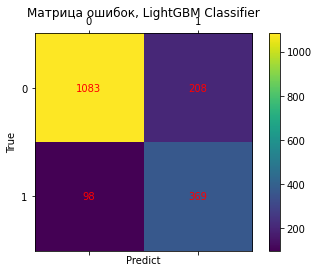

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_ax = ax.matshow(confusion_matrix(target_test, model_gb.predict(features_test_0)))
plt.title('Матрица ошибок, LightGBM Classifier')
fig.colorbar(cm_ax)
plt.xlabel('Predict')
plt.ylabel('True')

for i in range(len(confusion_matrix(target_test, model_gb.predict(features_test_0)))):
    for j in range(len(confusion_matrix(target_test, model_gb.predict(features_test_0)))):
        text = ax.text(j, i, confusion_matrix(target_test, model_gb.predict(features_test_0))[i, j],
                       ha="center", va="center", color="r")

Получилось довольно большое количество ложноположительных ответов. Это значит, что модель слишком часто ошибается в пользу менее распространенного "беглого" класса.

Примерно о том же говорит и соотношение precision-recall. Precision меньше recall свидетельствует о том, что при применении данной модели для выделения беглецов мы "зачерпнем" большое количество клиентов, которые и не думали уходить.

Построим ROC-кривую и посмотрим, как решения нашей модели отклоняются от случайного классификатора (когда вероятность правильно определить класс составляет 50%).

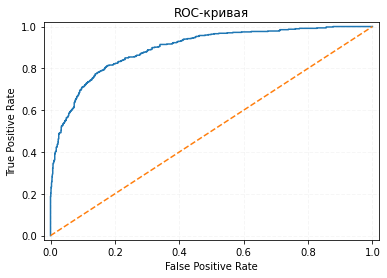

In [63]:
probabilities_test = model_gb.predict_proba(features_test_0)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([-0.02, 1.02])
plt.xlim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(alpha=0.1, linestyle='--', linewidth=1)
plt.show()

Результаты неплохие, но все же потолок явно не достигнут. 

Посмотрим, какие факторы для прогнозирования оттока внесли самый весомый вклад в результаты. Для этого выведем графики с признаками и отсортируем их по важности (для основных моделей).
Создадим функцию для отрисовки графика и вставим ее в другую функцию для вывода значимости фичей.

In [64]:
def draw_plot(data, series1, series2, plot_title):
    """
    Функция для построения столбчатой диаграммы.
    
    data - датафрейм с данными
    series1 - столбец по оси х
    series2 - столбец по оси y
    plot_title - заголовок графика
    """           
    plt.figure(figsize=(5,5))
    ax = sns.barplot(x=series1, y=series2, data=data)
    ax.set(title=plot_title)
    ax.title.set_position([0.5, 1.01])
    ax.grid(alpha=0.05, linestyle='--', linewidth=1)
    plt.show()

In [65]:
def feat_importance_draw(models, features, features0):
    """
    Функция для вывода графиков значимости прогнозирующих факторов. Не работает без функции draw_plot().
    
    models - словарь с моделями ({'name': model})
    features - датафрейм с прогнозируюшими факторами, где категориальные признаки закодированы
    features0 - датафрейм с прогнозируюшими факторами, где категориальные признаки без кодирования (для моделей градиентного бустинга, имеющих втроенные методы обработки подобных признаков)
    """           
    errors = []
    for name, model in models.items():
        try:
            if name == 'LGBMClassifier':
                df = pd.DataFrame({'Features': features0.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
            elif name == 'Logistic Regression' or name == 'Support Vector Classification':
                df = pd.DataFrame({'Features': features.columns, 'Importance': np.std(features)*model.coef_[0]}).sort_values(by='Importance', ascending=False)
            else:
                df = pd.DataFrame({'Features': features.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)  
            
            draw_plot(df, 'Importance', 'Features', name)
            
        except:
            errors.append(name)
            
    return ('Модели ' + ', '.join(errors) + ' не имеют атрибутов feature_importances_ или coef_')

Теперь применим функцию к нашим данным и выведем графики.

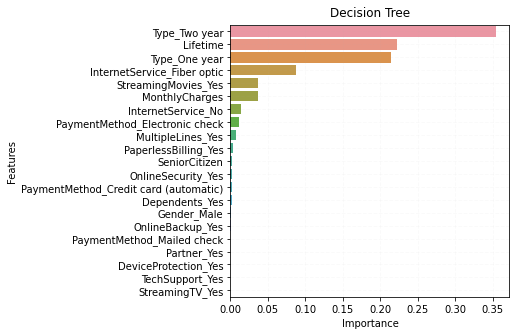

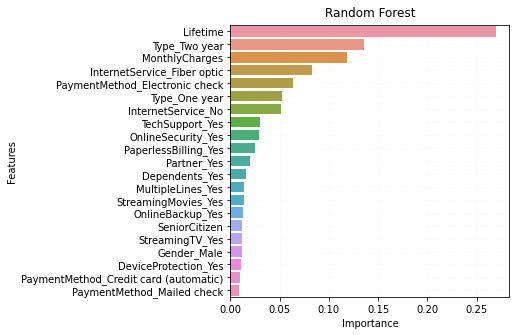

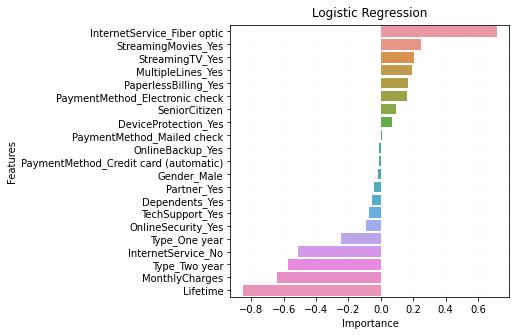

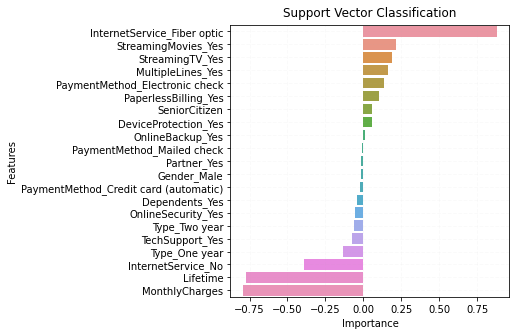

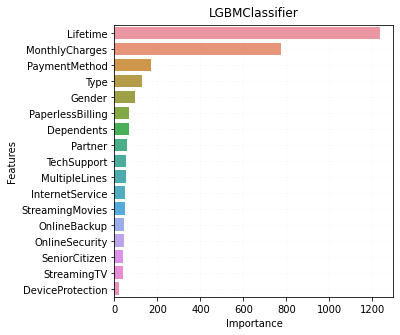

'Модели GaussianNB, KNeighbors Classifier, Dummy не имеют атрибутов feature_importances_ или coef_'

In [66]:
display(feat_importance_draw(models_list, features_test, features_test_0))

Интересно, что для моделей, основанных на дереве или ансамбле деревьев, самыми значимыми факторами оказались Type, Lifetime, MonthlyCharges, InternetService. Для логистической регрессии и метода опорных векторов эти признаки тоже среди лидеров, однако там также ощутимо важны стриминговые сервисы (Movies и TV). Причем с последними корреляция положительная, возможно, это связано с дороговизной этих сервисов.

### Вывод

По сравнению с Dummy все модели показали более высокий результат. Однако, лучшие прогнозы выдал LightGBM. На втором месте по разделению классов случайный лес. Наиболее значимыми для прогнозирования оказались признаки Type, Lifetime, MonthlyCharges и InternetService. Результат полностью совпал с итогами анализа корреляций выше.

## Общий вывод

При анализе данных о характеристиках клиентов обнаружены зависимости между фактом расторжения договора, длительностью использования услуг и производимыми платежами.

На основании предоставленных датафреймов обучен ряд моделей бинарной классификации. По качеству эффективнее всего оказались ансамблевые решения. Лучший итог показал взвешенный LightGBM (ROC-AUC с кросс-валидацией 0.884, на тестовой 0.895). Значение метрики ROC-AUC сопоставлено с значением Dummy-модели (0.505). В целом, ошибки всех моделей, рассмотренных в работе, оказались существенно меньше ошибки Dummy-модели, что говорит о более достоверных предсказаниях.

Необходимо отметить, что recall модели больше precision (0.790 и 0.640 соответственно). Это означает, что при прогнозировании модель чаще будет ошибаться в сторону положительного класса (churn=1, клиент ушел). Скорее всего, здесь необходимо исходить из задачи, насколько нам важно диагностировать потенциальных беглецов, и для удержания какого количества людей есть ресурсы. Или же нам целесообразнее сосредоточиться только на узком сегменте, который вероятнее уйдет. 

Для дальнейшего улучшения качества прогнозирования имеет смысл рассмотреть и другие важные факторы (например, объем предоставляемых услуг - количество минут, смс или гб трафика в пакете), влияющие на принятие решения абонентом о прекращении сотрудничества с оператором.